# このscriptは作成途中

This script corresponds to examples/run_bands

In [1]:
import aiida_vasp
print(aiida_vasp.__file__, aiida_vasp.__version__)

/home/max/.virtualenvs/aiida-vasp21/lib/python3.7/site-packages/aiida_vasp/__init__.py 2.1.1


In [2]:
"""
An example call script that performs a single static VASP calculation.

Performs a self consistent electron convergence run using the standard silicon structure.
"""
# pylint: disable=too-many-arguments
import numpy as np
from aiida.common.extendeddicts import AttributeDict
from aiida.orm import Code, Bool, Str
from aiida.plugins import DataFactory, WorkflowFactory
from aiida.engine import submit
from aiida import load_profile
load_profile()


def get_structure():
    """
    Set up Si primitive cell

    Si
       5.431
         0.0000000000000000    0.5000000000000000    0.5000000000000000
         0.5000000000000000    0.0000000000000000    0.5000000000000000
         0.5000000000000000    0.5000000000000000    0.0000000000000000
    Si
       2
    Direct
      0.8750000000000000  0.8750000000000000  0.8750000000000000
      0.1250000000000000  0.1250000000000000  0.1250000000000000

    """

    structure_data = DataFactory('structure')
    alat = 5.431
    lattice = np.array([[.5, 0, .5], [.5, .5, 0], [0, .5, .5]]) * alat
    structure = structure_data(cell=lattice)
    for pos_direct in ([0.875, 0.875, 0.875], [0.125, 0.125, 0.125]):
        pos_cartesian = np.dot(pos_direct, lattice)
        structure.append_atom(position=pos_cartesian, symbols='Si')
    return structure

In [46]:
def main(code_string, incar, kmesh, structure, potential_family, potential_mapping, options):
    """Main method to setup the calculation."""

    # First, we need to fetch the AiiDA datatypes which will
    # house the inputs to our calculation
    dict_data = DataFactory('dict')
    kpoints_data = DataFactory('array.kpoints')

    # Then, we set the workchain you would like to call
    workchain = WorkflowFactory('vasp.vasp')

    # And finally, we declare the options, settings and input containers
    settings = AttributeDict()
    inputs = AttributeDict()

    # Organize settings
    if False:
        # obsolete style
        settings.parser_settings = {'output_params': ['total_energies',
                                        'maximum_force', 'forces']}
    if False:
        # can't get force and trajectory
        print("alternative parser_settings")
        settings.parser_settings = {'misc': True, 'forces': True, 'trajectory': True}
        
    if True:
        # Ref. /home/max/Documents/aiida-vasp/aiida_vasp/parsers/vasp.py
        # DEFAULT_OPTIONS
        parser_settings = {'add_energies': True,
                           'add_dos': True, 
                       'add_forces': True,
                       'add_stress': True,
                       'add_trajectory': True,
                       'add_site_magnetixation': True,
                          'add_wavecar': True,
                          'add_chgcar': True}
        settings.parser_settings = parser_settings
        
        # ADDITIONAL_RETRIEVE_TEMPORARY_LIST: parseするためにdownloadするが、その後で消す。
        # ADDITIONAL_RETRIEVE_LIST: downloadする。
        
        # settings["ADDITIONAL_RETRIEVE_TEMPORARY_LIST"] = ["CHGCAR","WAVECAR"]
        settings["ADDITIONAL_RETRIEVE_LIST"] = ["CHGCAR","WAVECAR"]

    print("settings", settings)
        
    # Set inputs for the following WorkChain execution
    # Set code
    inputs.code = Code.get_from_string(code_string)
    # Set structure
    inputs.structure = structure
    # Set k-points grid density
    kpoints = kpoints_data()
    kpoints.set_kpoints_mesh(kmesh)
    inputs.kpoints = kpoints
    # Set parameters
    inputs.parameters = dict_data(dict=incar)
    # Set potentials and their mapping
    inputs.potential_family = Str(potential_family)
    inputs.potential_mapping = dict_data(dict=potential_mapping)
    # Set options
    inputs.options = dict_data(dict=options)
    # Set settings
    inputs.settings = dict_data(dict=settings)
    # Set workchain related inputs, in this case, give more explicit output to report
    inputs.verbose = Bool(True)
    # Submit the requested workchain with the supplied inputs
    future = submit(workchain, **inputs)
    print(future)
    return future

def execute_main():
    # Code_string is chosen among the list given by 'verdi code list'
    CODE_STRING = 'vasp_iceberg'

    # POSCAR equivalent
    # Set the silicon structure
    STRUCTURE = get_structure()

    # INCAR equivalent
    # Set input parameters
    INCAR = {'incar': {'prec': 'NORMAL', 'encut': 200, 
                       'ediff': 1E-4, 'ialgo': 38, 'ismear': -5, 'sigma': 0.1,
                      'lorbit': 11, # for PDOS 
                      }}

    # KPOINTS equivalent
    # Set kpoint mesh
    KMESH = [9, 9, 9]

    # POTCAR equivalent
    # Potential_family is chosen among the list given by
    # 'verdi data vasp-potcar listfamilies'
    POTENTIAL_FAMILY = 'PBE.54'
    # The potential mapping selects which potential to use, here we use the standard
    # for silicon, this could for instance be {'Si': 'Si_GW'} to use the GW ready
    # potential instead
    POTENTIAL_MAPPING = {'Si': 'Si'}

    # Jobfile equivalent
    # In options, we typically set scheduler options.
    # See https://aiida.readthedocs.io/projects/aiida-core/en/latest/scheduler/index.html
    # AttributeDict is just a special dictionary with the extra benefit that
    # you can set and get the key contents with mydict.mykey, instead of mydict['mykey']
    OPTIONS = AttributeDict()
    OPTIONS.account = ''
    OPTIONS.qos = ''
    OPTIONS.resources = {'num_machines': 1, 'num_mpiprocs_per_machine': 3}
    OPTIONS.queue_name = ''
    OPTIONS.max_wallclock_seconds = 3600
    OPTIONS.max_memory_kb = 10240000

    workchain = main(CODE_STRING, INCAR, KMESH, STRUCTURE, POTENTIAL_FAMILY, 
                     POTENTIAL_MAPPING, OPTIONS)
    return workchain

workchain = execute_main()

settings AttributeDict({'parser_settings': {'add_energies': True, 'add_dos': True, 'add_forces': True, 'add_stress': True, 'add_trajectory': True, 'add_site_magnetixation': True, 'add_wavecar': True, 'add_chgcar': True}, 'ADDITIONAL_RETRIEVE_LIST': ['CHGCAR', 'WAVECAR']})
uuid: dbf5b79f-a654-46ad-a73d-42e143fa35f7 (pk: 2492) (aiida.workflows:vasp.vasp)


In [47]:
workchain

<WorkChainNode: uuid: dbf5b79f-a654-46ad-a73d-42e143fa35f7 (pk: 2492) (aiida.workflows:vasp.vasp)>

In [48]:
from aiida.orm.nodes.process.calculation.calcjob import CalcJobNode
import time
waitsec =  5
future = None
while future is None:
    for node in workchain.get_outgoing().all_nodes():
        if isinstance(node,CalcJobNode):
            print(node)
            future = node
            break
    time.sleep(waitsec)

uuid: 8c0aceec-02b8-4cb4-b4e8-b937aa36a0fd (pk: 2494) (aiida.calculations:vasp.vasp)


In [49]:
import time
waitsec =  5
while not future.is_terminated:
    print("exception %s, sleep %d sec" % (future.exception, waitsec))
    time.sleep(waitsec)
print("finished_ok",future.is_finished_ok)
print("exit_message", future.exit_message)

finished_ok True
exit_message the sun is shining


2494
Info: Initiating graphviz engine: dot
Info: Recursing ancestors, max depth=None
Info: Recursing descendants, max depth=None
Success: Output file: 2494.dot.pdf


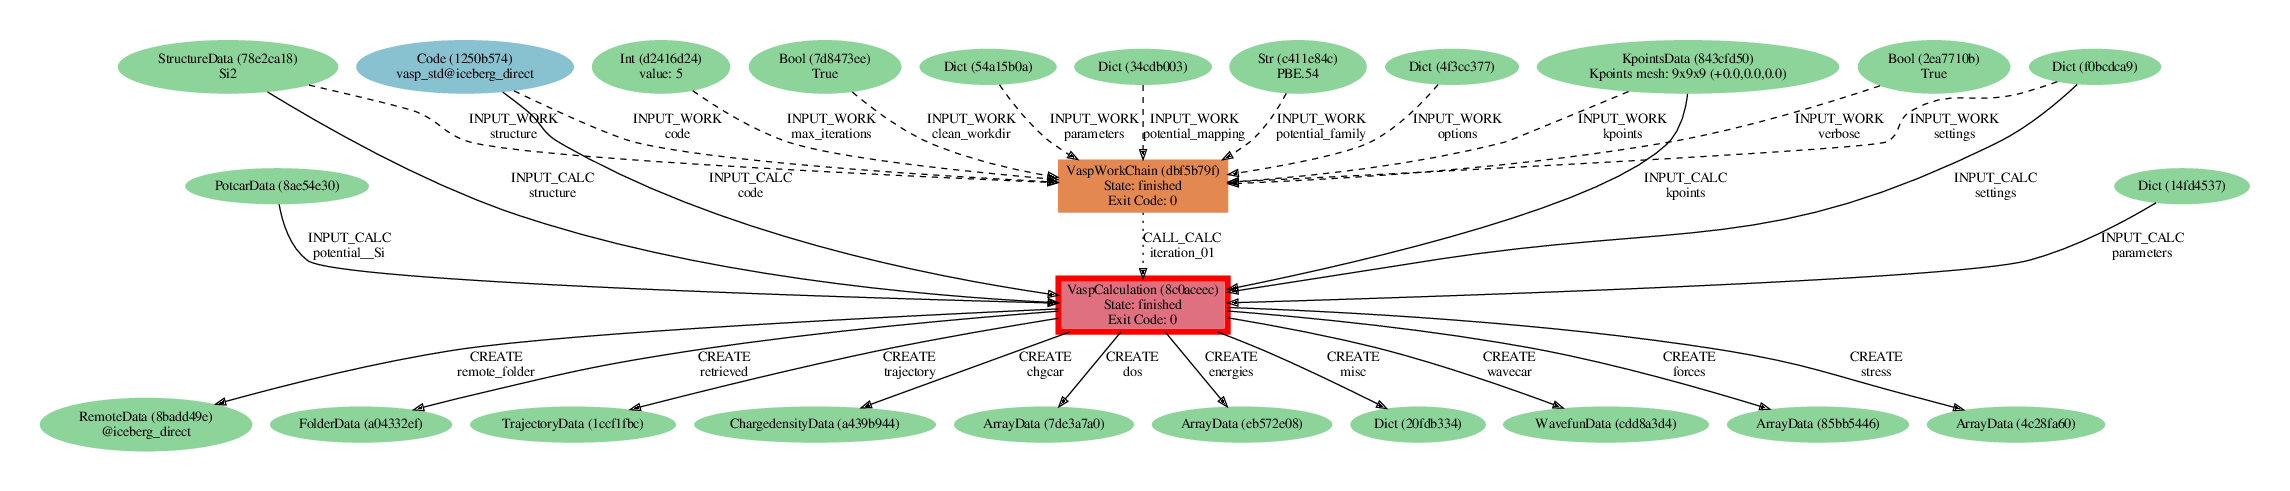

In [50]:
pk = future.pk
print(pk)
import subprocess
cmd = "verdi node graph generate {}".format(pk)
subprocess.call(cmd,shell=True)

from wand.image import Image as WImage
WImage(filename="{}.dot.pdf".format(pk))

In [51]:
!verdi process report $pk

*** 2494: None
*** (empty scheduler output file)
*** (empty scheduler errors file)
*** 0 LOG MESSAGES


In [53]:
!verdi calcjob outputls $pk

CHGCAR
CONTCAR
DOSCAR
EIGENVAL
OUTCAR
WAVECAR
_scheduler-stderr.txt
_scheduler-stdout.txt
vasp_output
vasprun.xml


In [52]:
!verdi calcjob outputcat $pk OUTCAR

 vasp.6.1.2 22Jul20 (build Jul 27 2021 15:58:46) complex                        
  
 executed on             LinuxIFC date 2021.08.05  10:29:00
 running on    3 total cores
 distrk:  each k-point on    3 cores,    1 groups
 distr:  one band on NCORE=   1 cores,    3 groups


--------------------------------------------------------------------------------------------------------


 INCAR:
 POTCAR:    PAW_PBE Si 05Jan2001                  
 POTCAR:    PAW_PBE Si 05Jan2001                  
   VRHFIN =Si: s2p2                                                                                 
   LEXCH  = PE                                                                                      
   EATOM  =   103.0669 eV,    7.5752 Ry                                                             
                                                                                                    
   TITEL  = PAW_PBE Si 05Jan2001                                                                    
  

In [54]:
!verdi process show $pk

Property     Value
-----------  ------------------------------------
type         VaspCalculation
state        Finished [0] the sun is shining
pk           2494
uuid         8c0aceec-02b8-4cb4-b4e8-b937aa36a0fd
label
description
ctime        2021-08-05 01:29:33.908209+00:00
mtime        2021-08-05 01:30:19.564319+00:00
computer     [4] iceberg_direct

Inputs      PK    Type
----------  ----  -------------
potential
    Si      1319  PotcarData
code        1601  Code
kpoints     2483  KpointsData
parameters  2493  Dict
settings    2488  Dict
structure   2482  StructureData

Outputs          PK  Type
-------------  ----  -----------------
chgcar         2498  ChargedensityData
dos            2499  ArrayData
energies       2500  ArrayData
forces         2503  ArrayData
misc           2501  Dict
remote_folder  2495  RemoteData
retrieved      2496  FolderData
stress         2504  ArrayData
trajectory     2497  TrajectoryData
wavecar        2502  WavefunData

Caller          PK  Type
-------

設定にadd_*を入れ、
"add_wavecar":Trueとしたのでwavecar nodeができている。

In [55]:
future.outputs.wavecar

<WavefunData: uuid: cdd8a3d4-3812-47c3-af32-74b138929071 (pk: 2502)>

In [56]:
future.outputs.wavecar.attributes

{'filename': 'WAVECAR'}

In [57]:
future.outputs.wavecar.filename

'WAVECAR'

WavefunDataはaiida.orm.SinglefileDataの小クラスである。
SinglefileDataはfile pathが設定されており、fileをopenする関数を持つ。

In [66]:
# ファイルの中身は以下で取るとある。
content = future.outputs.wavecar.get_content()

# しかし、テキストファイルでないと読めない。

UnicodeDecodeError: 'utf-8' codec can't decode byte 0xa1 in position 6: invalid start byte

In [64]:
# binaryファイルの場合はmode="rb"でopenする。
#fin = future.outputs.wavecar.open(future.outputs.wavecar.filename,"rb")
fin = future.outputs.wavecar.open(mode="rb")

content = fin.read()
print(len(content))

import hashlib
m=hashlib.md5()
m.update(content)
print(m.hexdigest())

765952
98c3be913a9c2d7d15b25d19f6bd80f3


/home/max/.virtualenvs/aiida-vasp21/lib/python3.7/site-packages/aiida/orm/nodes/node.py:73: AiidaDeprecationWarning: 
The method `del` was called on the return value of `<WavefunData: uuid: cdd8a3d4-3812-47c3-af32-74b138929071 (pk: 2502)>.open()` outside of a context manager.
Please wrap this call inside `with <node instance>.open(): ...` to silence this warning. This will raise an exception, starting from `aiida-core==2.0.0`.
The offending call comes from:
  File "/tmp/ipykernel_11495/3734887151.py", line 3, in <module>
    fin = future.outputs.wavecar.open(mode="rb")

  warnings.warn(msg, AiidaDeprecationWarning)  # pylint: disable=no-member
/home/max/.virtualenvs/aiida-vasp21/lib/python3.7/site-packages/aiida/orm/nodes/node.py:73: AiidaDeprecationWarning: 
The method `read` was called on the return value of `<WavefunData: uuid: cdd8a3d4-3812-47c3-af32-74b138929071 (pk: 2502)>.open()` outside of a context manager.
Please wrap this call inside `with <node instance>.open(): ...` to sil

In [59]:
from getnodefile import CopyInputOutputFiles
copyvaspio = CopyInputOutputFiles(["INCAR","KPOINTS","POSCAR"],
                                  ["CONTCAR","OUTCAR","DOSCAR","WAVECAR","vasprun.xml"])
dirname = "VASP_RESULT_{}".format(pk)
print(dirname)
import os
if not os.path.isdir(dirname):
    os.mkdir(dirname)
copyvaspio.copy(future, dirname)

VASP_RESULT_2494


0

In [16]:
!md5sum $dirname/WAVECAR

81f144ad18bdc213d488e9c774ca0f7e  VASP_RESULT_2308/WAVECAR


md5sumが同じであるので同じファイルである。

同様にchgcarができている。

In [17]:
future.outputs.chgcar

<ChargedensityData: uuid: 1bfc3bc9-0db3-4153-96de-a067d50bfb4c (pk: 2312)>

継続計算のためのWAVECARをlocalPCに取得した。

WAVECARを次の計算時に計算サーバーに送る。

In [31]:
def main2(code_string, incar, kmesh, structure, potential_family, 
          potential_mapping, options, calcjob=None):
    """Main method to setup the calculation."""

    # First, we need to fetch the AiiDA datatypes which will
    # house the inputs to our calculation
    dict_data = DataFactory('dict')
    kpoints_data = DataFactory('array.kpoints')

    # Then, we set the workchain you would like to call
    workchain = WorkflowFactory('vasp.vasp')

    # And finally, we declare the options, settings and input containers
    settings = AttributeDict()
    inputs = AttributeDict()

    # Organize settings
    if False:
        # obsolete style
        settings.parser_settings = {'output_params': ['total_energies',
                                        'maximum_force', 'forces']}
    if False:
        # can't get force and trajectory
        print("alternative parser_settings")
        settings.parser_settings = {'misc': True, 'forces': True, 'trajectory': True}
        
    if True:
        # Ref. /home/max/Documents/aiida-vasp/aiida_vasp/parsers/vasp.py
        # DEFAULT_OPTIONS
        parser_settings = {'add_energies': True,
                           'add_dos': True, 
                       'add_forces': True,
                       'add_stress': True,
                       'add_trajectory': True,
                       'add_site_magnetixation': True,
                          'add_wavecar': True,
                          'add_chgcar': True}
        settings.parser_settings = parser_settings
        #settings["ADDITIONAL_RETRIEVE_TEMPORARY_LIST"] = ["CHGCAR","WAVECAR"]
        settings["ADDITIONAL_RETRIEVE_LIST"] = ["CHGCAR","WAVECAR"]
        
    # Set inputs for the following WorkChain execution
    # Set code
    inputs.code = Code.get_from_string(code_string)
    # Set structure
    inputs.structure = structure
    # Set k-points grid density
    kpoints = kpoints_data()
    kpoints.set_kpoints_mesh(kmesh)
    inputs.kpoints = kpoints
    # Set parameters
    inputs.parameters = dict_data(dict=incar)
    # Set potentials and their mapping
    inputs.potential_family = Str(potential_family)
    inputs.potential_mapping = dict_data(dict=potential_mapping)
    
    #
    inputs.wavecar = calcjob.outputs.wavecar
    
    
    # Set options
    inputs.options = dict_data(dict=options)
    # Set settings
    inputs.settings = dict_data(dict=settings)
    # Set workchain related inputs, in this case, give more explicit output to report
    inputs.verbose = Bool(True)
    # Submit the requested workchain with the supplied inputs
    future = submit(workchain, **inputs)
    print(future)
    return future

def execute_main2(calcjob):
    # Code_string is chosen among the list given by 'verdi code list'
    CODE_STRING = 'vasp_iceberg'

    # POSCAR equivalent
    # Set the silicon structure
    STRUCTURE = get_structure()

    # INCAR equivalent
    # Set input parameters
    INCAR = {'incar': {'istart': 1,
                       'prec': 'NORMAL', 'encut': 200, 
                       'ediff': 1E-4, 'ialgo': 38, 'ismear': -5, 'sigma': 0.1,
                      'lorbit': 11, # for PDOS 
                      }}

    # KPOINTS equivalent
    # Set kpoint mesh
    KMESH = [9, 9, 9]

    # POTCAR equivalent
    # Potential_family is chosen among the list given by
    # 'verdi data vasp-potcar listfamilies'
    POTENTIAL_FAMILY = 'PBE.54'
    # The potential mapping selects which potential to use, here we use the standard
    # for silicon, this could for instance be {'Si': 'Si_GW'} to use the GW ready
    # potential instead
    POTENTIAL_MAPPING = {'Si': 'Si'}

    # Jobfile equivalent
    # In options, we typically set scheduler options.
    # See https://aiida.readthedocs.io/projects/aiida-core/en/latest/scheduler/index.html
    # AttributeDict is just a special dictionary with the extra benefit that
    # you can set and get the key contents with mydict.mykey, instead of mydict['mykey']
    OPTIONS = AttributeDict()
    OPTIONS.account = ''
    OPTIONS.qos = ''
    OPTIONS.resources = {'num_machines': 1, 'num_mpiprocs_per_machine': 3}
    OPTIONS.queue_name = ''
    OPTIONS.max_wallclock_seconds = 3600
    OPTIONS.max_memory_kb = 10240000

    workchain = main2(CODE_STRING, INCAR, KMESH, STRUCTURE, POTENTIAL_FAMILY, 
                     POTENTIAL_MAPPING, OPTIONS, calcjob=calcjob)
    return workchain

workchain = execute_main2(future)

uuid: 0905852b-4660-4d1e-98e8-4ca43d96a1c1 (pk: 2364) (aiida.workflows:vasp.vasp)


In [28]:
workchain.exit_message

In [32]:
raise

RuntimeError: No active exception to reraise

In [45]:
# also aiida SeeK-path

# KpointsDataにlineモードがある。

In [86]:
# pymatgenでのKpointsのとり方
STRUCTURE = get_structure()
from pymatgen.symmetry.kpath import KPathSeek

from pymatgen.io.vasp.inputs import Kpoints

struc = STRUCTURE.get_pymatgen()
kpath = KPathSeek(struc)

py_kpts = Kpoints.automatic_linemode(divisions=40,ibz=kpath)
kpoint_path_filename = "KPOINTS.{}".format(pk)
py_kpts.write_file(kpoint_path_filename)
print("save to",kpoint_path_filename)
print("----------")
print(py_kpts)
print("----------")

from parsevasp.kpoints import Kpoints
vasp_kpoints_list = Kpoints(file_path=kpoint_path_filename)

save to KPOINTS.2494
----------
Line_mode KPOINTS file
40
Line_mode
Reciprocal
0.0 0.0 0.0 ! GAMMA
0.5 0.0 0.5 ! X

0.5 0.0 0.5 ! X
0.625 0.25 0.625 ! U

0.375 0.375 0.75 ! K
0.0 0.0 0.0 ! GAMMA

0.0 0.0 0.0 ! GAMMA
0.5 0.5 0.5 ! L

0.5 0.5 0.5 ! L
0.5 0.25 0.75 ! W

0.5 0.25 0.75 ! W
0.5 0.0 0.5 ! X


----------


In [89]:
vasp_kpoints_list.entries

{'comment': 'Line_mode KPOINTS file',
 'divisions': None,
 'shifts': None,
 'points': [<parsevasp.kpoints.Kpoint at 0x7f694f2b6910>,
 'tetra': None,
 'tetra_volume': None,
 'mode': 'line',
 'centering': None,
 'num_kpoints': 40}

In [100]:
for points in vasp_kpoints_list.entries["points"]:
    print(points.point)

[0. 0. 0.]
[0.5 0.  0.5]
[0.5 0.  0.5]
[0.625 0.25  0.625]
[0.375 0.375 0.75 ]
[0. 0. 0.]
[0. 0. 0.]
[0.5 0.5 0.5]
[0.5 0.5 0.5]
[0.5  0.25 0.75]
[0.5  0.25 0.75]
[0.5 0.  0.5]


これはKpoints型なのでvasp.vaspのinputのKpointsData型が必要・・・。

In [94]:
kpoints_data = DataFactory('array.kpoints')
kpoints = kpoints_data()
kpoints.set_kpoints(vasp_kpoints_list)

TypeError: len() of unsized object

aiidaの方にもseekpathがあるがそのままでは使えない。

参考のために以下に書く。

In [12]:
from aiida.tools.data.array import kpoints
print(type(STRUCTURE))
kpts = kpoints.get_kpoints_path(STRUCTURE, method="seekpath")

<class 'aiida.orm.nodes.data.structure.StructureData'>


{'parameters': <Dict: uuid: 5ecee370-e3a7-4603-8d9f-aa84dcf7096c (unstored)>,
 'conv_structure': <StructureData: uuid: d7077a1a-7bdf-4777-8b36-9b4b61edfd39 (unstored)>,
 'primitive_structure': <StructureData: uuid: 39f84ab0-db5d-48bf-b985-830d55dcc1b6 (unstored)>}

In [13]:
kpts['parameters'].attributes

{'point_coords': {'GAMMA': [0.0, 0.0, 0.0],
  'X': [0.5, 0.0, 0.5],
  'L': [0.5, 0.5, 0.5],
  'W': [0.5, 0.25, 0.75],
  'W_2': [0.75, 0.25, 0.5],
  'K': [0.375, 0.375, 0.75],
  'U': [0.625, 0.25, 0.625]},
 'path': [('GAMMA', 'X'),
  ('X', 'U'),
  ('K', 'GAMMA'),
  ('GAMMA', 'L'),
  ('L', 'W'),
  ('W', 'X')],
 'has_inversion_symmetry': True,
 'augmented_path': False,
 'bravais_lattice': 'cF',
 'bravais_lattice_extended': 'cF2',
 'conv_lattice': array([[5.431, 0.   , 0.   ],
        [0.   , 5.431, 0.   ],
        [0.   , 0.   , 5.431]]),
 'conv_positions': array([[0.  , 0.  , 0.5 ],
        [0.75, 0.75, 0.75],
        [0.  , 0.5 , 0.  ],
        [0.75, 0.25, 0.25],
        [0.5 , 0.  , 0.  ],
        [0.25, 0.75, 0.25],
        [0.5 , 0.5 , 0.5 ],
        [0.25, 0.25, 0.75]]),
 'conv_types': array([14, 14, 14, 14, 14, 14, 14, 14], dtype=int32),
 'primitive_lattice': array([[0.    , 2.7155, 2.7155],
        [2.7155, 0.    , 2.7155],
        [2.7155, 2.7155, 0.    ]]),
 'primitive_position

In [8]:
from aiida.orm import load_node
pk = 2494
future = load_node(pk)

In [13]:
def main3(code_string, incar, structure, potential_family, 
          potential_mapping, options, calcjob=None):
    """Main method to setup the calculation."""

    # First, we need to fetch the AiiDA datatypes which will
    # house the inputs to our calculation
    dict_data = DataFactory('dict')
    kpoints_data = DataFactory('array.kpoints')

    # Then, we set the workchain you would like to call
    workchain = WorkflowFactory('vasp.bands')

    # And finally, we declare the options, settings and input containers
    settings = AttributeDict()
    inputs = AttributeDict()

    # Organize settings
    if False:
        # obsolete style
        settings.parser_settings = {'output_params': ['total_energies',
                                        'maximum_force', 'forces']}
    if False:
        # can't get force and trajectory
        print("alternative parser_settings")
        settings.parser_settings = {'misc': True, 'forces': True, 'trajectory': True}
        
    if True:
        # Ref. /home/max/Documents/aiida-vasp/aiida_vasp/parsers/vasp.py
        # DEFAULT_OPTIONS
        parser_settings = {'add_energies': True,
                           'add_dos': True, 
                       'add_forces': True,
                       'add_stress': True,
                       'add_trajectory': True,
                       'add_site_magnetixation': True,
                           'add_bands': True, 
                          'add_wavecar': True,
                          'add_chgcar': True}
        settings.parser_settings = parser_settings
        # settings["ADDITIONAL_RETRIEVE_TEMPORARY_LIST"] = ["CHGCAR","WAVECAR"]
        settings["ADDITIONAL_RETRIEVE_LIST"] = ["CHGCAR","WAVECAR"]
        
    # Set inputs for the following WorkChain execution
    # Set code
    inputs.code = Code.get_from_string(code_string)
    # Set structure
    inputs.structure = structure
    # 
    # Set parameters
    inputs.parameters = dict_data(dict=incar)
    # Set potentials and their mapping
    inputs.potential_family = Str(potential_family)
    inputs.potential_mapping = dict_data(dict=potential_mapping)
    
    #
    if False:
        inputs.wavecar = calcjob.outputs.wavecar
        inputs.chgcar = calcjob.outputs.wavecar
    
    # Set options
    inputs.options = dict_data(dict=options)
    # Set settings
    inputs.settings = dict_data(dict=settings)
    # Set workchain related inputs, in this case, give more explicit output to report
    inputs.verbose = Bool(True)
    # Submit the requested workchain with the supplied inputs
    future = submit(workchain, **inputs)
    print(future)
    return future

def execute_main3(calcjob, ):
    # Code_string is chosen among the list given by 'verdi code list'
    CODE_STRING = 'vasp_iceberg'

    # POSCAR equivalent
    # Set the silicon structure
    STRUCTURE = get_structure()

    # INCAR equivalent
    # Set input parameters
    INCAR = {'incar': {
                       'icharg': 11, # fixed chgcar
                       'prec': 'NORMAL', 'encut': 200, 
                       'ediff': 1E-4, 'ialgo': 38, 'ismear': -5, 'sigma': 0.1,
                      'lorbit': 11, # for PDOS 
                      }}

    # KPOINTS equivalent
    # Set kpoint mesh
    KMESH = [9, 9, 9]

    # POTCAR equivalent
    # Potential_family is chosen among the list given by
    # 'verdi data vasp-potcar listfamilies'
    POTENTIAL_FAMILY = 'PBE.54'
    # The potential mapping selects which potential to use, here we use the standard
    # for silicon, this could for instance be {'Si': 'Si_GW'} to use the GW ready
    # potential instead
    POTENTIAL_MAPPING = {'Si': 'Si'}

    # Jobfile equivalent
    # In options, we typically set scheduler options.
    # See https://aiida.readthedocs.io/projects/aiida-core/en/latest/scheduler/index.html
    # AttributeDict is just a special dictionary with the extra benefit that
    # you can set and get the key contents with mydict.mykey, instead of mydict['mykey']
    OPTIONS = AttributeDict()
    OPTIONS.account = ''
    OPTIONS.qos = ''
    OPTIONS.resources = {'num_machines': 1, 'num_mpiprocs_per_machine': 3}
    OPTIONS.queue_name = ''
    OPTIONS.max_wallclock_seconds = 3600
    OPTIONS.max_memory_kb = 10240000

    workchain = main3(CODE_STRING, INCAR, STRUCTURE, POTENTIAL_FAMILY, 
                     POTENTIAL_MAPPING, OPTIONS, calcjob=calcjob)
    return workchain

workchain = execute_main3(future)

ValueError: Error occurred validating port 'inputs.restart_folder': required value was not provided for 'restart_folder'

In [ ]:
コメント：STRUCTUREからvasp_kpoints_listは生成できる。

In [ ]:
workchain3.exit_message

In [ ]:
workchain3.outputs.

1.
ValueError: Error occurred validating port

from class PortValidationError(Exception):
https://aiida.readthedocs.io/projects/aiida-core/en/latest/_modules/plumpy/ports.html

2.
class PortNamespace(collections.abc.MutableMapping, Port):

def validate_dynamic_ports():
https://aiida.readthedocs.io/projects/aiida-core/en/latest/_modules/plumpy/ports.html


In [21]:
from aiida_vasp.utils.aiida_utils import get_data_node, get_data_class
wavefun_data_class = get_data_class('vasp.wavefun')

In [22]:
wavefun_data = DataFactory('vasp.wavefun')

In [23]:
print(isinstance(future.outputs.wavecar, wavefun_data),
isinstance(future.outputs.wavecar, wavefun_data_class))

True True
